1. Data Preprocessing: Clean the dataset and handle missing or irregular data. Encode the categorical features (such as Token_1, Token_3, etc.) using techniques like one-hot encoding or label encoding.
2. Model Selection: Choose a classification algorithm (e.g., Decision Tree, Random Forest, or K-Nearest Neighbors) to classify the coffee type based on the input features.
3. Model Training: Train the model using the dataset and evaluate its performance on a test set.
4. Bot Integration: Use the trained model to create a bot. When users provide their preferences (such as time of day, coffee strength, sweetness level, etc.), the bot will recommend an appropriate coffee type (espresso, latte, cappuccino, etc.). The Box can be done using streamlit cloud.



In [ ]:
!pip install shap -q


import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Import filters to remove unnecessary warnings
from warnings import simplefilter
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Import filters to remove unnecessary warnings
from warnings import simplefilter
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
import shap

In [3]:
import pandas as pd

# Read the Excel file, skipping the first two rows
df = pd.read_excel('coffee_recommendation_dataset.xlsx')

# Reset the index if needed
df = df.reset_index(drop=True)

# Display the first few rows to verify
print(df.head())

     Token_0  Token_1            Token_2  Token_3    Token_4 Token_5 Token_6  \
0  afternoon  regular  lightly sweetened     skim        hot      no    high   
1    evening   strong  lightly sweetened   almond       iced     yes  medium   
2  afternoon     mild  lightly sweetened  regular  cold brew     yes    high   
3    morning   strong        unsweetened   almond  cold brew     yes    high   
4    morning  regular              sweet     none        hot      no     low   

   Token_7 Token_8             Token_9     Label  
0  Arabica   small               vegan  espresso  
1  Arabica   small               vegan     latte  
2  Arabica   large                none  espresso  
3  Arabica   large               vegan  espresso  
4  Robusta   small  lactose-intolerant     latte  


In [4]:
df.dtypes

Token_0    object
Token_1    object
Token_2    object
Token_3    object
Token_4    object
Token_5    object
Token_6    object
Token_7    object
Token_8    object
Token_9    object
Label      object
dtype: object

In [6]:
# Check for duplicates in the entire dataset
duplicates = df.duplicated()
# If there are any duplicates, the 'duplicates' variable will contain True for those rows
if duplicates.any():
    # Get the rows with duplicates
    duplicate_rows = df[duplicates]
    print(duplicate_rows)
else:
    print("No duplicates found in the dataset.")

       Token_0  Token_1            Token_2  Token_3 Token_4 Token_5 Token_6  \
506    morning     mild              sweet     skim    iced      no  medium   
624  afternoon  regular  lightly sweetened  regular     hot      no    high   
811    morning  regular        unsweetened     none    iced      no    high   
882    morning  regular  lightly sweetened   almond    iced      no     low   
914    evening     mild              sweet     none    iced      no    high   

     Token_7 Token_8             Token_9     Label  
506    blend   small               vegan     latte  
624    blend   large                none  espresso  
811  Arabica   large                none  espresso  
882  Robusta   large                none  espresso  
914  Arabica   large  lactose-intolerant  espresso  


In [7]:
df.describe()  # Summary statistics for numerical columns

,Token_0,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,Token_9,Label
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,3,3,3,4,3,2,3,3,3,3,3
top,morning,regular,unsweetened,none,hot,yes,low,Arabica,large,lactose-intolerant,cappuccino
freq,348,345,343,267,336,506,337,366,356,350,361


In [8]:
print("Missing data information:")
missing_data = df.isnull().sum()
missing_percent = 100 * df.isnull().sum() / len(df)
missing_table = pd.concat([missing_data, missing_percent], axis=1, keys=['Total Missing', 'Percent Missing'])
total_rows = len(df)

for column, missing_count in missing_data.items():
    print(f"{column}: {missing_count} missing values ({missing_count/total_rows:.2%})")
if missing_data.sum() == 0:
    print("No missing data found in the dataset.")
else:
    print(f"\nTotal number of missing values: {missing_data.sum()}")
    print(f"Percentage of missing data: {missing_data.sum() / np.product(df.shape):.2%}")

Missing data information:
Token_0: 0 missing values (0.00%)
Token_1: 0 missing values (0.00%)
Token_2: 0 missing values (0.00%)
Token_3: 0 missing values (0.00%)
Token_4: 0 missing values (0.00%)
Token_5: 0 missing values (0.00%)
Token_6: 0 missing values (0.00%)
Token_7: 0 missing values (0.00%)
Token_8: 0 missing values (0.00%)
Token_9: 0 missing values (0.00%)
Label: 0 missing values (0.00%)
No missing data found in the dataset.


In [10]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Perform one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_columns, prefix=categorical_columns)

# Display the encoded dataframe
print("\nEncoded DataFrame:")
print(df_encoded.head())
print("\nEncoded DataFrame Info:")
print(df_encoded.info())


Encoded DataFrame:
   Token_0_afternoon  Token_0_evening  Token_0_morning  Token_1_mild  \
0               True            False            False         False   
1              False             True            False         False   
2               True            False            False          True   
3              False            False             True         False   
4              False            False             True         False   

   Token_1_regular  Token_1_strong  Token_2_lightly sweetened  Token_2_sweet  \
0             True           False                       True          False   
1            False            True                       True          False   
2            False           False                       True          False   
3            False            True                      False          False   
4             True           False                      False           True   

   Token_2_unsweetened  Token_3_almond  ...  Token_7_blend  Token_


Frequency Analysis for Token_0:
Token_0
morning      348
afternoon    327
evening      325
Name: count, dtype: int64


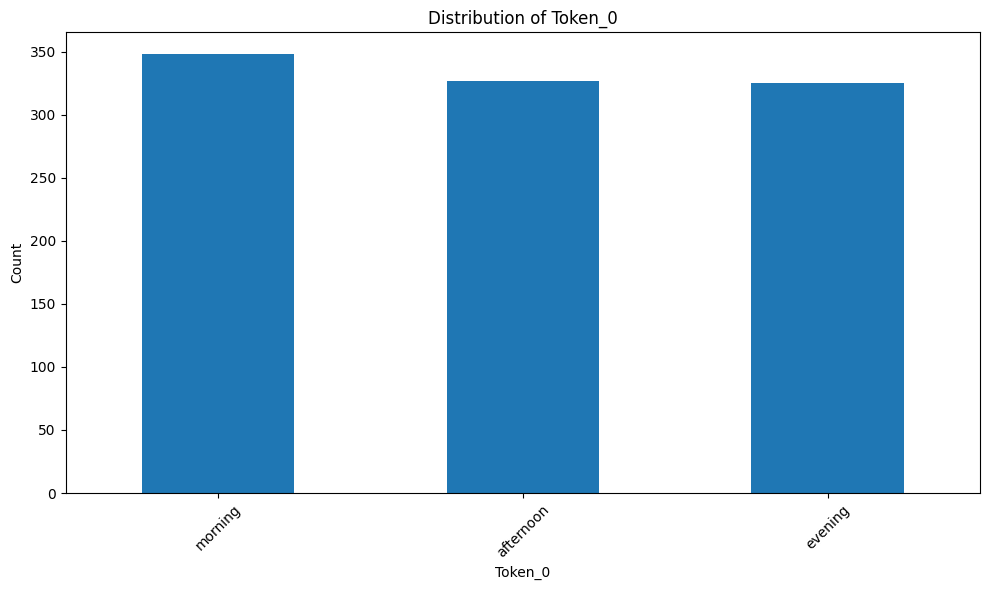


Frequency Analysis for Token_1:
Token_1
regular    345
mild       342
strong     313
Name: count, dtype: int64


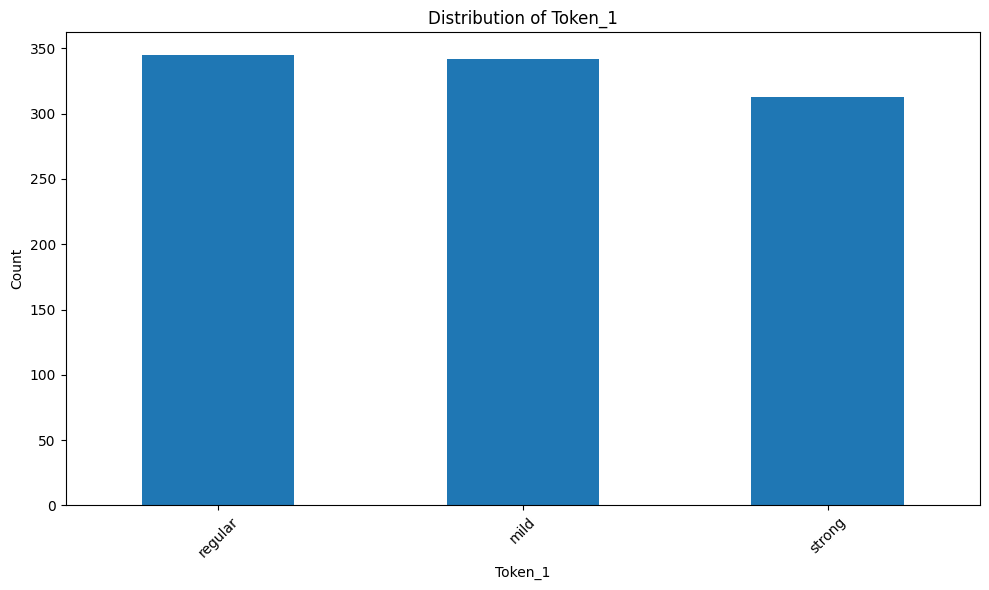


Frequency Analysis for Token_2:
Token_2
unsweetened          343
lightly sweetened    333
sweet                324
Name: count, dtype: int64


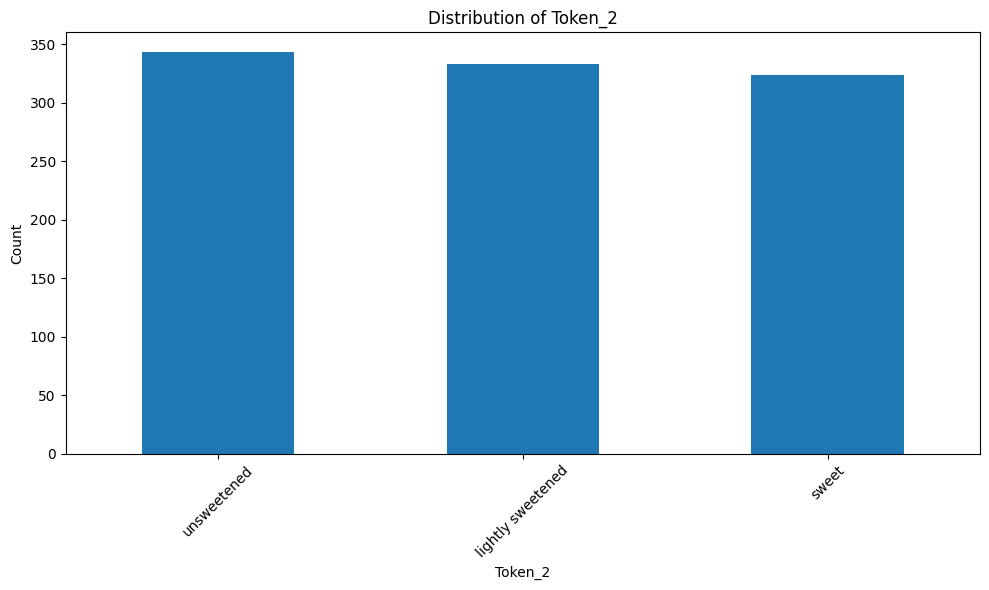


Frequency Analysis for Token_3:
Token_3
none       267
almond     261
regular    252
skim       220
Name: count, dtype: int64


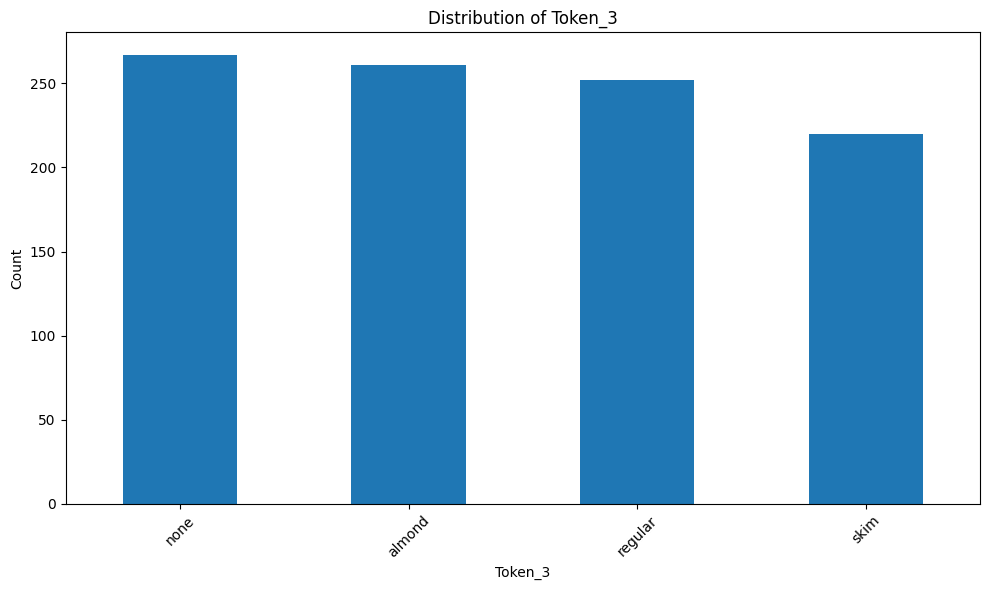


Frequency Analysis for Token_4:
Token_4
hot          336
cold brew    333
iced         331
Name: count, dtype: int64


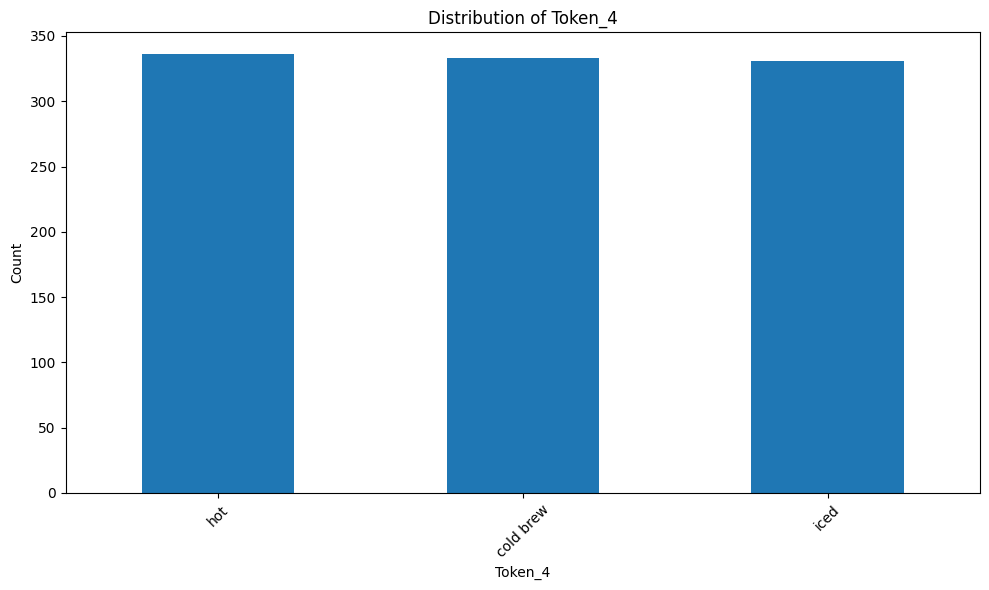


Frequency Analysis for Token_5:
Token_5
yes    506
no     494
Name: count, dtype: int64


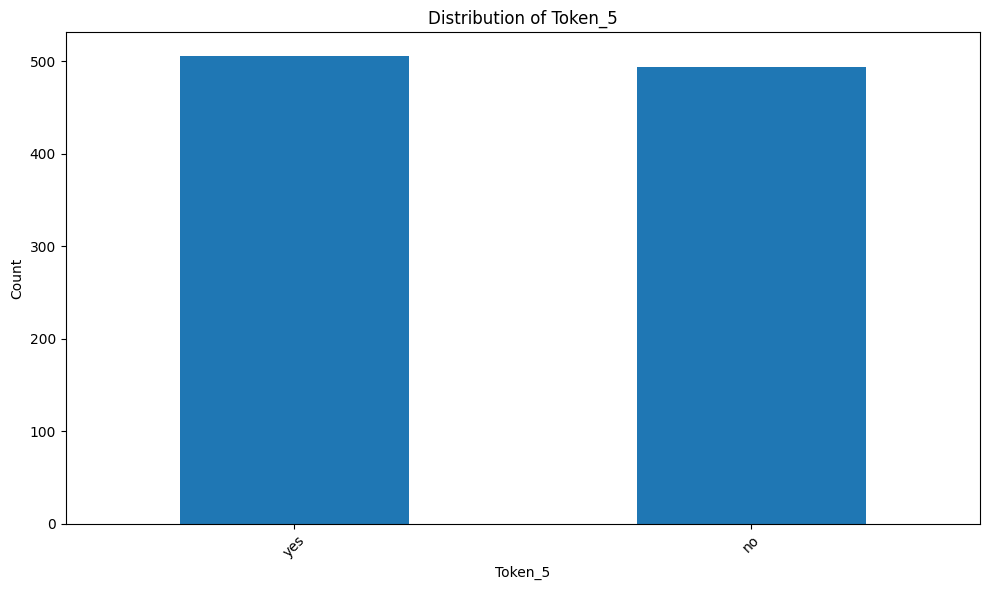


Frequency Analysis for Token_6:
Token_6
low       337
high      332
medium    331
Name: count, dtype: int64


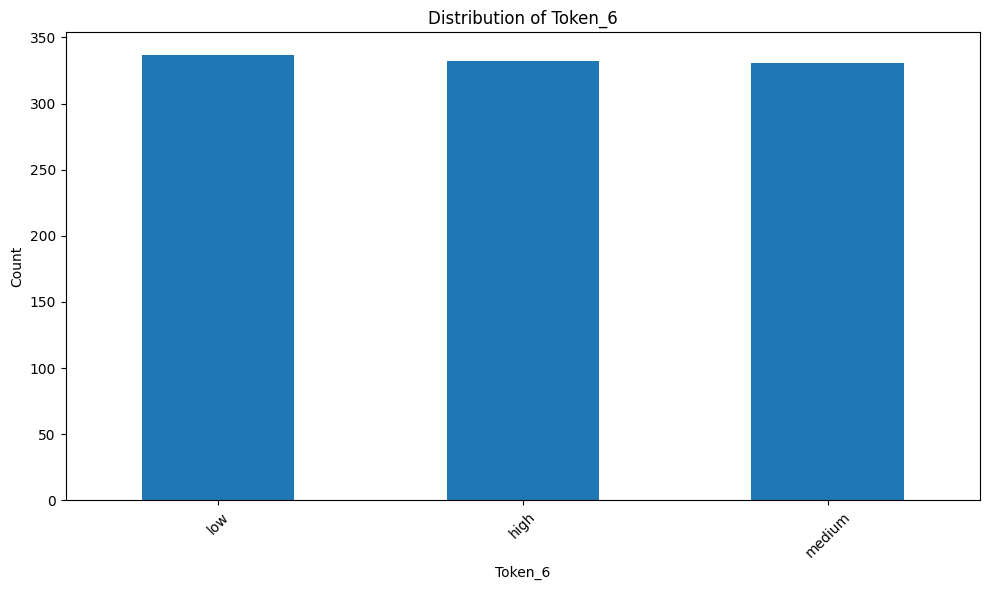


Frequency Analysis for Token_7:
Token_7
Arabica    366
Robusta    319
blend      315
Name: count, dtype: int64


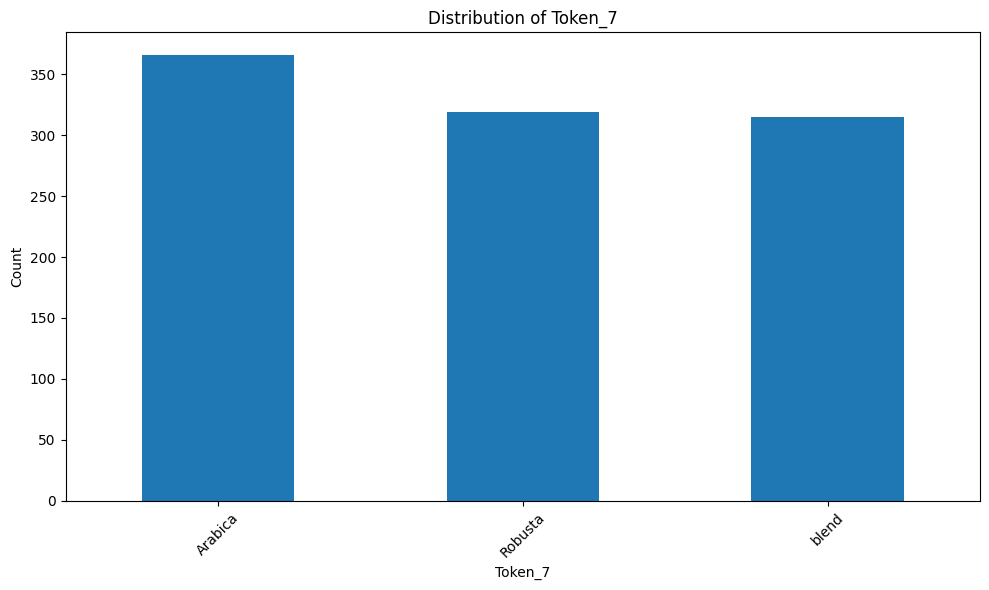


Frequency Analysis for Token_8:
Token_8
large     356
small     338
medium    306
Name: count, dtype: int64


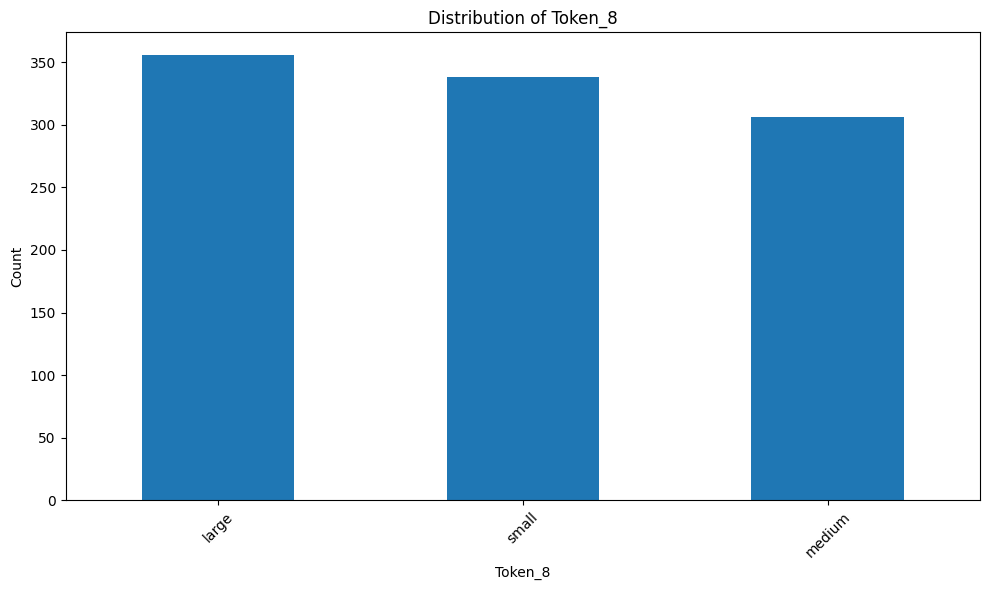


Frequency Analysis for Token_9:
Token_9
lactose-intolerant    350
vegan                 344
none                  306
Name: count, dtype: int64


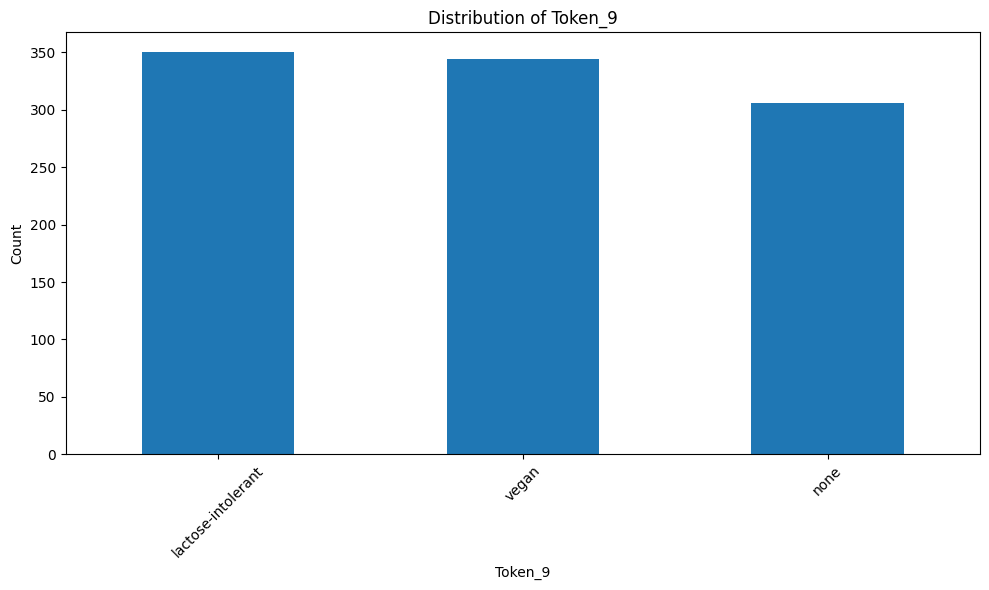


Frequency Analysis for Label:
Label
cappuccino    361
espresso      328
latte         311
Name: count, dtype: int64


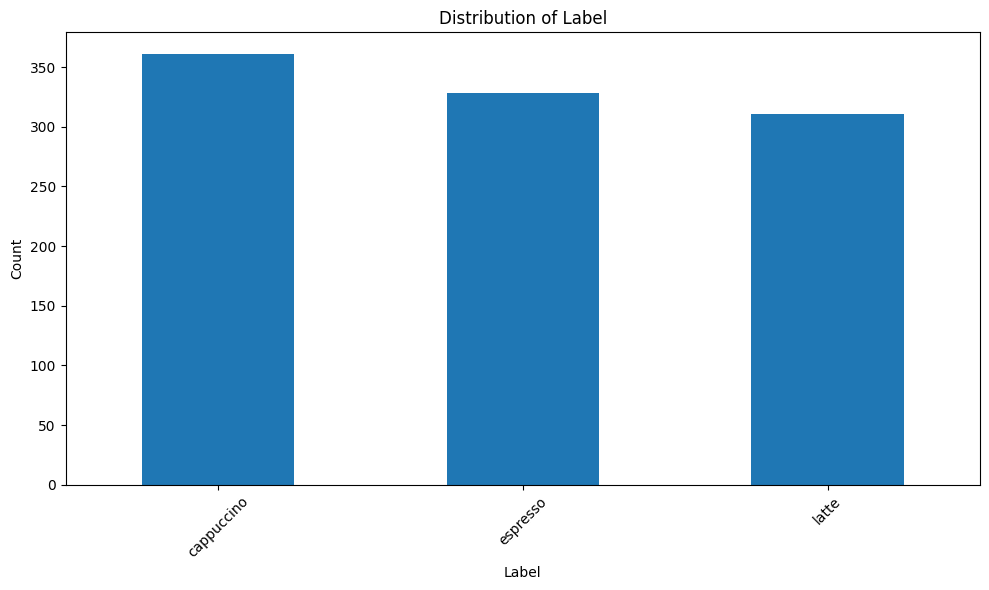

In [17]:
# 1. Frequency Analysis
def frequency_analysis(df, column):
    return df[column].value_counts()

# 2. Bar Plot
def plot_bar(df, column):
    plt.figure(figsize=(10, 6))
    df[column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

for column in categorical_columns:
    print(f"\nFrequency Analysis for {column}:")
    print(frequency_analysis(df, column))
    plot_bar(df, column)